In [2]:
import os
import tensorflow as tf
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.metrics import CategoricalAccuracy
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np
import pandas as pd
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials
from hyperopt.pyll.base import scope
from hyperopt import space_eval

# Постановка задачи

Задача - определить тип аномалии на изображении. Считаем, что аномалии бывают 3 видов:
- переэкспонированное фото
- смазанное фото
- отсутствие объекта на фото

## Примеры изображений


In [3]:
paths = {
    'bad_exposition': [
        "../dataset-001/dataset/bad_exposition/a0580-kme_350_N1.5.jpg",
        "../dataset-001/dataset/bad_exposition/a0580-kme_350_N1.jpg",
        "../dataset-001/dataset/bad_exposition/a0580-kme_350_P1.5.jpg",
        "../dataset-001/dataset/bad_exposition/a0580-kme_350_P1.jpg",
    ],
    'bad_quality': [
        '../dataset-001/dataset/bad_quality/4fromGOPR1087.MP4.jpg',
        '../dataset-001/dataset/bad_quality/4fromGOPR1097.MP4.jpg',
        '../dataset-001/dataset/bad_quality/5fromGOPR0977.jpg',
        '../dataset-001/dataset/bad_quality/5fromGOPR0973.jpg',
    ],
    'no_person': [
        '../dataset-001/dataset/no_person/000000000285.jpg',
        '../dataset-001/dataset/no_person/000000001675.jpg',
        '../dataset-001/dataset/no_person/000000001818.jpg',
        '../dataset-001/dataset/no_person/000000002149.jpg',
    ]
    
}

### Плохая экспозиция

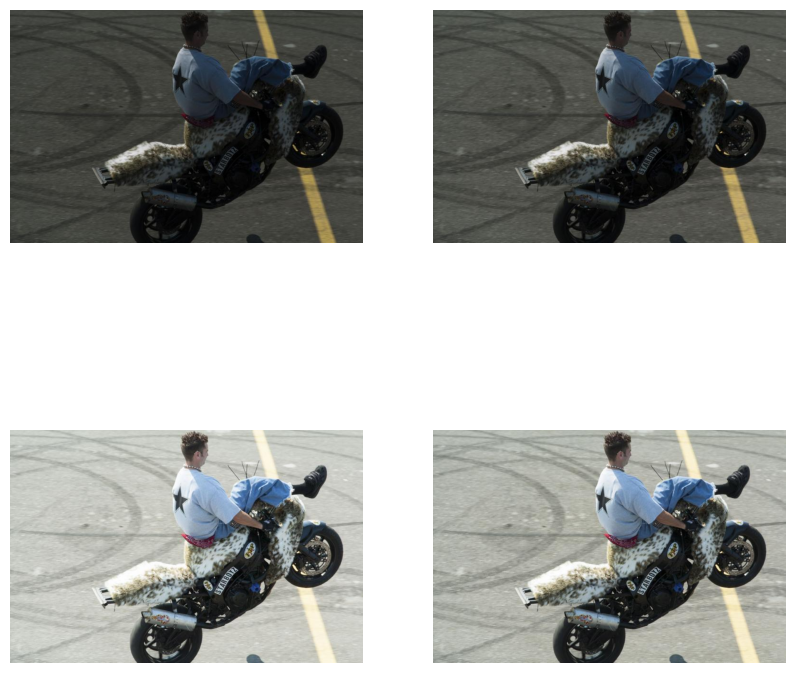

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i, path in enumerate(paths['bad_exposition']):
    im = cv2.imread(path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    ax = axes[i // 2, i % 2]
    ax.imshow(im)
    ax.axis('off')
plt.show()

### Смазанное фото

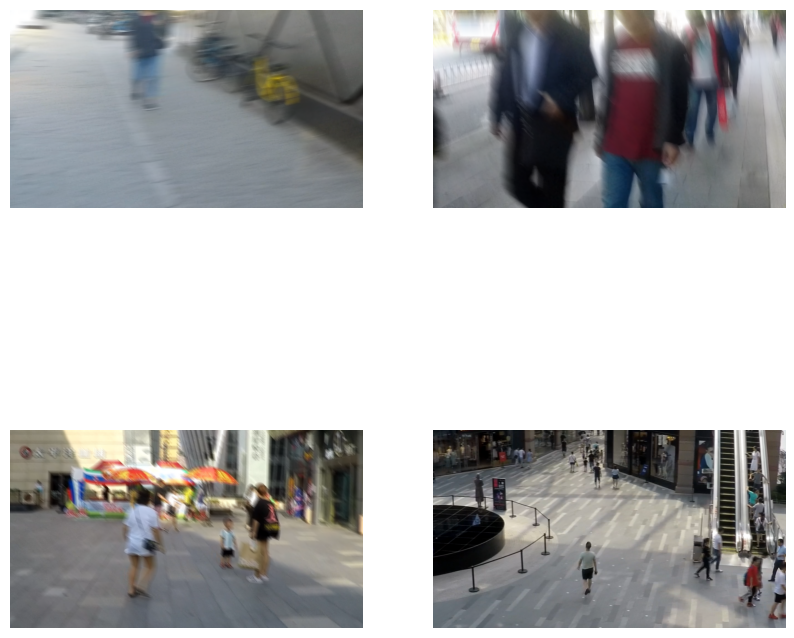

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i, path in enumerate(paths['bad_quality']):
    im = cv2.imread(path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    ax = axes[i // 2, i % 2]
    ax.imshow(im)
    ax.axis('off')
plt.show()

### Нет человека на фото

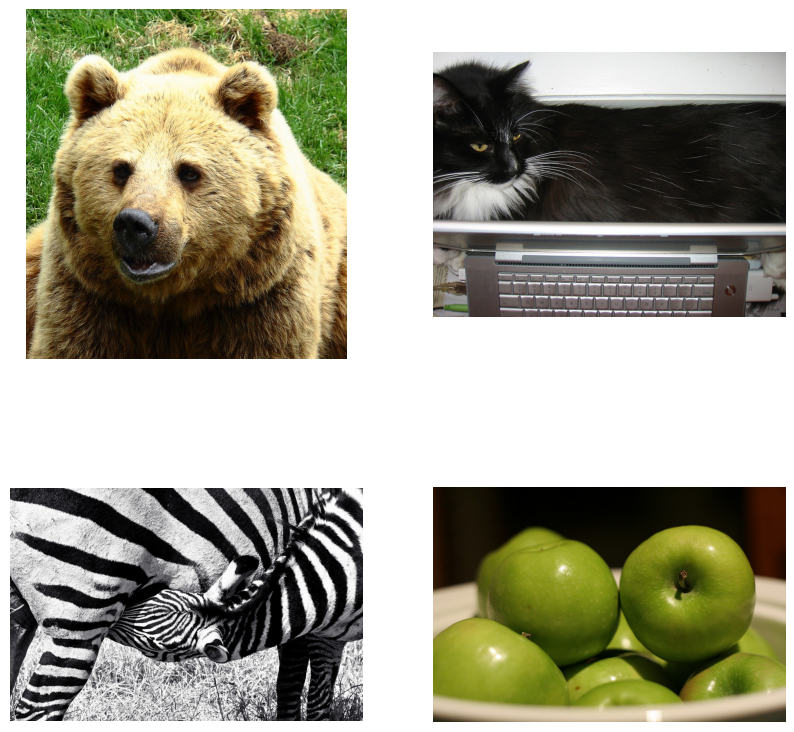

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i, path in enumerate(paths['no_person']):
    im = cv2.imread(path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    ax = axes[i // 2, i % 2]
    ax.imshow(im)
    ax.axis('off')
plt.show()

# Dataset preparation

In [7]:
PATH_TO_DATA = '../dataset-001/dataset/'

In [8]:
all_classes = os.listdir(PATH_TO_DATA)

In [9]:
all_classes

['bad_exposition', 'bad_quality', 'good_quality_photos', 'no_person']

In [10]:
dataset = []
for class_name in all_classes:
    class_images = glob.glob(f"{PATH_TO_DATA}{class_name}/*")
    class_images = [[img_path, class_name] for img_path in class_images]
    dataset.extend(class_images)
dataset_df = pd.DataFrame(dataset, index=range(len(dataset)), columns=['img_path', 'class'])
dataset_df

,img_path,class
0,../dataset-001/dataset/bad_exposition\a0002-dg...,bad_exposition
1,../dataset-001/dataset/bad_exposition\a0002-dg...,bad_exposition
2,../dataset-001/dataset/bad_exposition\a0002-dg...,bad_exposition
3,../dataset-001/dataset/bad_exposition\a0002-dg...,bad_exposition
4,../dataset-001/dataset/bad_exposition\a0008-WP...,bad_exposition
...,...,...
6705,../dataset-001/dataset/no_person\000000580757.jpg,no_person
6706,../dataset-001/dataset/no_person\000000581100.jpg,no_person
6707,../dataset-001/dataset/no_person\000000581482.jpg,no_person
6708,../dataset-001/dataset/no_person\000000581615.jpg,no_person


In [11]:
train_df, test_df = train_test_split(
    dataset_df, 
    test_size=0.2, 
    random_state=42
)

In [12]:
train_df

,img_path,class
5736,../dataset-001/dataset/no_person\000000327780.jpg,no_person
4245,../dataset-001/dataset/good_quality_photos\000...,good_quality_photos
6326,../dataset-001/dataset/no_person\000000485130.jpg,no_person
1807,../dataset-001/dataset/bad_quality\1fromGOPR09...,bad_quality
4099,../dataset-001/dataset/good_quality_photos\000...,good_quality_photos
...,...,...
3772,../dataset-001/dataset/good_quality_photos\000...,good_quality_photos
5191,../dataset-001/dataset/no_person\000000188689.jpg,no_person
5226,../dataset-001/dataset/no_person\000000196754.jpg,no_person
5390,../dataset-001/dataset/no_person\000000235057.jpg,no_person


In [13]:
test_df.shape

(1342, 2)

In [14]:
train_df.shape

(5368, 2)

# Тренировка и CV

In [15]:
IMG_SIZE = (224, 224)
K_FOLDS = 5

In [16]:
space = {
    "batch_size": hp.choice('batch_size', list(range(8, 128))), 
    "act_fn": hp.choice('act_fn', ['sigmoid', 'elu', 'relu', 'relu6', 'tanh']),
    "model": hp.choice('model', ['efficientnet', 'inception_v3', 'resnet50']),
    "opt": hp.choice('opt', [
        'adadelta',
        'adagrad',
        'adam',
        'ftlr',
        'nadam',
        'rmsprop',
        'sgd'
    ]),
    'num_epochs': hp.randint('num_epochs', 5),
    'lr': hp.uniform('lr', 1e-5, 1e-2),
    "latent_dim": hp.choice('latent_dim', list(range(20, 100))) #размерность промежуточного слоя
}

In [17]:
def build_model(config, backbone_model):
    x = backbone_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(config['latent_dim'], activation=config['act_fn'])(x)
    predictions = Dense(len(all_classes), activation='softmax')(x)
    model = Model(inputs=backbone_model.input, outputs=predictions)
    if config['opt'] == 'adadelta':
      opt = tf.keras.optimizers.Adadelta(learning_rate=config['lr'])
    if config['opt'] == 'adagrad':
      opt = tf.keras.optimizers.Adagrad(learning_rate=config['lr'])
    if config['opt'] == 'adam':
      opt = tf.keras.optimizers.Adam(learning_rate=config['lr'])
    if config['opt'] == 'ftlr':
      opt = tf.keras.optimizers.Ftrl(learning_rate=config['lr'])
    if config['opt'] == 'nadam':
      opt = tf.keras.optimizers.Nadam(learning_rate=config['lr'])
    if config['opt'] == 'rmsprop':
      opt = tf.keras.optimizers.RMSprop(learning_rate=config['lr'])
    if config['opt'] == 'sgd':
      opt = tf.keras.optimizers.SGD(learning_rate=config['lr'])
    model.compile(
        optimizer=opt, 
        loss='categorical_crossentropy', 
        metrics=[
          tf.keras.metrics.CategoricalAccuracy(),
          tf.keras.metrics.Precision(), 
          tf.keras.metrics.Recall(),
          tf.keras.metrics.AUC()
        ]
    )

    return model

In [18]:
def cross_validation(model, generator, batch_size, num_folds, num_epochs):
    cv_scores = []
    kf = KFold(n_splits=num_folds, random_state=None, shuffle=True)
    X = np.array(train_df["img_path"])
    i=0
    for train_index, test_index in kf.split(X):
        train_data = X[train_index]
        test_data = X[test_index]
        NUM_STEPS = int(len(train_data) / batch_size) + 1
        train_data = train_df.loc[train_df["img_path"].isin(list(train_data))]
        valid_data = train_df.loc[train_df["img_path"].isin(list(test_data))]
        train_gen = generator.flow_from_dataframe(
            dataframe=train_data,
            x_col = 'img_path',
            y_col = 'class',
            class_mode = 'categorical',
            classes = all_classes,
            target_size = IMG_SIZE,
            color_mode = 'rgb',
            batch_size = batch_size,
            validate_filenames=False
        )
        valid_gen = generator.flow_from_dataframe(
            dataframe=valid_data,
            x_col = 'img_path',
            y_col = 'class',
            class_mode = 'categorical',
            classes = all_classes,
            target_size = IMG_SIZE,
            color_mode = 'rgb',
            batch_size = batch_size,
            validate_filenames=False
        )
        hist = model.fit(
            train_gen,
            steps_per_epoch= NUM_STEPS,
            epochs = num_epochs,
            validation_data=valid_gen
        )
        print(hist.history)
        if i == 0:
           score_name = 'val_categorical_accuracy'
        else:
           score_name = f'val_categorical_accuracy_{i}'
        print("Available metrics:", hist.history.keys())
#         best_metric_key = max(hist.history, key=lambda k: hist.history[k][-1])
        if score_name in hist.history:
            cv_scores.append(hist.history[score_name][-1])
        i += 1
        return cv_scores

In [19]:
def objective(params):
  print("Selected model hyperparams:")
  print(params)
  config = {
      'batch_size': params['batch_size'],
      'act_fn': params['act_fn'],
      'model': params['model'],
      'opt': params['opt'],
      'num_epochs': params['act_fn'],
      'lr': params['lr'],
      'latent_dim': params['latent_dim']
  }
  if config['model'] == 'resnet50':
      from tensorflow.keras.applications.resnet50 import ResNet50 as BackboneModel
      from tensorflow.keras.applications.resnet50 import preprocess_input as preprocessing_function
  if config['model'] == 'efficientnet':
     from tensorflow.keras.applications.efficientnet import EfficientNetB2 as BackboneModel
     from tensorflow.keras.applications.efficientnet import preprocess_input as preprocessing_function
  if config['model'] == 'inception_v3':
      from tensorflow.keras.applications.inception_v3 import InceptionV3 as BackboneModel
      from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocessing_function
  generator = ImageDataGenerator(
      preprocessing_function=preprocessing_function
  )
  backbone = BackboneModel(weights='imagenet', include_top=False)
  model = build_model(config, backbone)
  cv = cross_validation(
      model=model,
      generator=generator,
      batch_size=params['batch_size'],
      num_folds=K_FOLDS,
      num_epochs=params['num_epochs']
  )
  mean_cv = np.mean(cv)
  print(f'Avg CV categorical accuracy score: {mean_cv}')
  return {'loss': -mean_cv, 'status': STATUS_OK, 'metrics': mean_cv}

In [80]:
trials = Trials()
best = fmin(
    fn=objective,
    space=space, 
    algo=tpe.suggest, 
    max_evals=7, 
    trials=trials
)

Selected model hyperparams:                                                                                            
{'act_fn': 'tanh', 'batch_size': 9, 'latent_dim': 35, 'lr': 0.0004595009791178407, 'model': 'efficientnet', 'num_epochs': 0, 'opt': 'adadelta'}
Found 3578 non-validated image filenames belonging to 4 classes.                                                       

Found 1790 non-validated image filenames belonging to 4 classes.                                                       

{}                                                                                                                     
Available metrics:                                                                                                     
dict_keys([])                                                                                                          
Avg CV categorical accuracy score: nan                                                                                 
Selected model

D:\ProgramFilesi\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,

D:\ProgramFilesi\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Found 3578 non-validated image filenames belonging to 4 classes.                                                       

Found 1790 non-validated image filenames belonging to 4 classes.                                                       

Epoch 1/2                                                                                                              

 50%|██████████████████████████████████                                  | 1/2 [00:03<00:01,  1.89s/trial, best loss=?]

C:\Users\danii\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



  1/398 ━━━━━━━━━━━━━━━━━━━━ 1:24:38 13s/step - auc_22: 0.6296 - categorical_accuracy: 0.2222 - loss: 1.3346 - precision_22: 0.0000e+00 - recall_22: 0.0000e+00
  2/398 ━━━━━━━━━━━━━━━━━━━━ 12:40 2s/step - auc_22: 0.6160 - categorical_accuracy: 0.2778 - loss: 1.3573 - precision_22: 0.0000e+00 - recall_22: 0.0000e+00   
  3/398 ━━━━━━━━━━━━━━━━━━━━ 12:16 2s/step - auc_22: 0.6088 - categorical_accuracy: 0.2840 - loss: 1.3698 - precision_22: 0.0667 - recall_22: 0.0123        
  4/398 ━━━━━━━━━━━━━━━━━━━━ 12:14 2s/step - auc_22: 0.6044 - categorical_accuracy: 0.2685 - loss: 1.3751 - precision_22: 0.0778 - recall_22: 0.0162
  5/398 ━━━━━━━━━━━━━━━━━━━━ 11:59 2s/step - auc_22: 0.6025 - categorical_accuracy: 0.2681 - loss: 1.3790 - precision_22: 0.0986 - recall_22: 0.0219
  6/398 ━━━━━━━━━━━━━━━━━━━━ 11:46 2s/step - auc_22: 0.6009 - categorical_accuracy: 0.2698 - loss: 1.3828 - precision_22: 0.1334 - recall_22: 0.0306
  7/398 ━━━━━━━━━━━━━━━━━━━━ 11:37 2s/step - auc_22: 0.6021 - categorical_ac

 91/398 ━━━━━━━━━━━━━━━━━━━━ 9:01 2s/step - auc_22: 0.7823 - categorical_accuracy: 0.5212 - loss: 1.0875 - precision_22: 0.6872 - recall_22: 0.3058
 92/398 ━━━━━━━━━━━━━━━━━━━━ 8:59 2s/step - auc_22: 0.7832 - categorical_accuracy: 0.5225 - loss: 1.0855 - precision_22: 0.6886 - recall_22: 0.3076
 93/398 ━━━━━━━━━━━━━━━━━━━━ 8:57 2s/step - auc_22: 0.7842 - categorical_accuracy: 0.5238 - loss: 1.0835 - precision_22: 0.6899 - recall_22: 0.3094
 94/398 ━━━━━━━━━━━━━━━━━━━━ 8:56 2s/step - auc_22: 0.7851 - categorical_accuracy: 0.5251 - loss: 1.0814 - precision_22: 0.6912 - recall_22: 0.3111
 95/398 ━━━━━━━━━━━━━━━━━━━━ 8:54 2s/step - auc_22: 0.7861 - categorical_accuracy: 0.5264 - loss: 1.0794 - precision_22: 0.6925 - recall_22: 0.3129
 96/398 ━━━━━━━━━━━━━━━━━━━━ 8:52 2s/step - auc_22: 0.7870 - categorical_accuracy: 0.5276 - loss: 1.0774 - precision_22: 0.6937 - recall_22: 0.3146
 97/398 ━━━━━━━━━━━━━━━━━━━━ 8:50 2s/step - auc_22: 0.7879 - categorical_accuracy: 0.5289 - loss: 1.0754 - preci

181/398 ━━━━━━━━━━━━━━━━━━━━ 6:18 2s/step - auc_22: 0.8414 - categorical_accuracy: 0.6069 - loss: 0.9439 - precision_22: 0.7621 - recall_22: 0.4256
182/398 ━━━━━━━━━━━━━━━━━━━━ 6:16 2s/step - auc_22: 0.8418 - categorical_accuracy: 0.6075 - loss: 0.9427 - precision_22: 0.7626 - recall_22: 0.4266
183/398 ━━━━━━━━━━━━━━━━━━━━ 6:14 2s/step - auc_22: 0.8423 - categorical_accuracy: 0.6082 - loss: 0.9415 - precision_22: 0.7631 - recall_22: 0.4276
184/398 ━━━━━━━━━━━━━━━━━━━━ 6:12 2s/step - auc_22: 0.8427 - categorical_accuracy: 0.6088 - loss: 0.9403 - precision_22: 0.7636 - recall_22: 0.4285
185/398 ━━━━━━━━━━━━━━━━━━━━ 6:11 2s/step - auc_22: 0.8431 - categorical_accuracy: 0.6095 - loss: 0.9391 - precision_22: 0.7640 - recall_22: 0.4294
186/398 ━━━━━━━━━━━━━━━━━━━━ 6:09 2s/step - auc_22: 0.8435 - categorical_accuracy: 0.6101 - loss: 0.9379 - precision_22: 0.7645 - recall_22: 0.4304
187/398 ━━━━━━━━━━━━━━━━━━━━ 6:07 2s/step - auc_22: 0.8439 - categorical_accuracy: 0.6108 - loss: 0.9368 - preci

271/398 ━━━━━━━━━━━━━━━━━━━━ 3:40 2s/step - auc_22: 0.8705 - categorical_accuracy: 0.6528 - loss: 0.8577 - precision_22: 0.7928 - recall_22: 0.4931
272/398 ━━━━━━━━━━━━━━━━━━━━ 3:38 2s/step - auc_22: 0.8707 - categorical_accuracy: 0.6532 - loss: 0.8569 - precision_22: 0.7930 - recall_22: 0.4937
273/398 ━━━━━━━━━━━━━━━━━━━━ 3:36 2s/step - auc_22: 0.8710 - categorical_accuracy: 0.6536 - loss: 0.8561 - precision_22: 0.7933 - recall_22: 0.4943
274/398 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - auc_22: 0.8712 - categorical_accuracy: 0.6539 - loss: 0.8554 - precision_22: 0.7935 - recall_22: 0.4948
275/398 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - auc_22: 0.8714 - categorical_accuracy: 0.6543 - loss: 0.8546 - precision_22: 0.7938 - recall_22: 0.4954
276/398 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - auc_22: 0.8717 - categorical_accuracy: 0.6547 - loss: 0.8539 - precision_22: 0.7940 - recall_22: 0.4960
277/398 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - auc_22: 0.8719 - categorical_accuracy: 0.6551 - loss: 0.8531 - preci

361/398 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - auc_22: 0.8884 - categorical_accuracy: 0.6823 - loss: 0.7979 - precision_22: 0.8095 - recall_22: 0.5376
362/398 ━━━━━━━━━━━━━━━━━━━━ 1:02 2s/step - auc_22: 0.8886 - categorical_accuracy: 0.6825 - loss: 0.7974 - precision_22: 0.8097 - recall_22: 0.5380
363/398 ━━━━━━━━━━━━━━━━━━━━ 1:00 2s/step - auc_22: 0.8887 - categorical_accuracy: 0.6828 - loss: 0.7968 - precision_22: 0.8098 - recall_22: 0.5384
364/398 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - auc_22: 0.8889 - categorical_accuracy: 0.6831 - loss: 0.7963 - precision_22: 0.8100 - recall_22: 0.5389 
365/398 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - auc_22: 0.8890 - categorical_accuracy: 0.6833 - loss: 0.7957 - precision_22: 0.8101 - recall_22: 0.5393
366/398 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - auc_22: 0.8892 - categorical_accuracy: 0.6836 - loss: 0.7952 - precision_22: 0.8102 - recall_22: 0.5397
367/398 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - auc_22: 0.8893 - categorical_accuracy: 0.6838 - loss: 0.7946 - precisio

D:\ProgramFilesi\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



398/398 ━━━━━━━━━━━━━━━━━━━━ 86s 215ms/step - auc_22: 0.0000e+00 - categorical_accuracy: 0.0000e+00 - loss: 0.0000e+00 - precision_22: 0.0000e+00 - recall_22: 0.0000e+00 - val_auc_22: 0.9843 - val_categorical_accuracy: 0.8877 - val_loss: 0.3295 - val_precision_22: 0.9003 - val_recall_22: 0.8575

{'auc_22': [0.9479975700378418, 0.0], 'categorical_accuracy': [0.7836780548095703, 0.0], 'loss': [0.5828527212142944, 0.0], 'precision_22': [0.860977292060852, 0.0], 'recall_22': [0.6992733478546143, 0.0], 'val_auc_22': [0.9842985272407532, 0.9842985272407532], 'val_categorical_accuracy': [0.8877094984054565, 0.8877094984054565], 'val_loss': [0.3295368254184723, 0.3295368254184723], 'val_precision_22': [0.900293231010437, 0.900293231010437], 'val_recall_22': [0.8575419187545776, 0.8575419187545776]}
Available metrics:                                                                                                     
dict_keys(['auc_22', 'categorical_accuracy', 'loss', 'precision_22', 'recall_2

In [81]:
best_config = space_eval(space, best)

In [82]:
print("Best params: {}".format(best_config))

Best params: {'act_fn': 'tanh', 'batch_size': 9, 'latent_dim': 33, 'lr': 0.002334157071002784, 'model': 'resnet50', 'num_epochs': 2, 'opt': 'sgd'}


In [20]:
best_config = {'act_fn': 'tanh', 'batch_size': 9, 'latent_dim': 33, 'lr': 0.002334157071002784, 'model': 'resnet50', 'num_epochs': 2, 'opt': 'sgd'}

# Train final model

In [21]:
if best_config['model'] == 'resnet50':
    from tensorflow.keras.applications.resnet50 import ResNet50 as BackboneModel
    from tensorflow.keras.applications.resnet50 import preprocess_input as preprocessing_function
if best_config['model'] == 'efficientnet':
    from tensorflow.keras.applications.efficientnet import EfficientNetB2 as BackboneModel
    from tensorflow.keras.applications.efficientnet import preprocess_input as preprocessing_function
if best_config['model'] == 'inception_v3':
    from tensorflow.keras.applications.inception_v3 import InceptionV3 as BackboneModel
    from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocessing_function
generator = ImageDataGenerator(
    preprocessing_function=preprocessing_function
)
backbone = BackboneModel(weights='imagenet', include_top=False)
model = build_model(best_config, backbone)

In [22]:
train_gen = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col = 'img_path',
    y_col = 'class',
    class_mode = 'categorical',
    classes = all_classes,
    target_size = IMG_SIZE,
    color_mode = 'rgb',
    batch_size = best_config['batch_size']
)
test_gen = generator.flow_from_dataframe( # его кроссвалидация не видела
    dataframe=test_df,
    x_col = 'img_path',
    y_col = 'class',
    class_mode = 'categorical',
    classes = train_gen.class_indices.keys(),
    target_size = IMG_SIZE,
    color_mode = 'rgb',
    batch_size = best_config['batch_size']
)

Found 5368 validated image filenames belonging to 4 classes.
Found 1342 validated image filenames belonging to 4 classes.


In [23]:
NUM_STEPS = int(len(train_df) / best_config['batch_size']) + 1
hist = model.fit(
    train_gen,
    steps_per_epoch= NUM_STEPS,
    epochs = best_config['num_epochs'],
    validation_data=test_gen
)

Epoch 1/2


C:\Users\danii\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


597/597 ━━━━━━━━━━━━━━━━━━━━ 935s 2s/step - auc: 0.8991 - categorical_accuracy: 0.7062 - loss: 0.7386 - precision: 0.7920 - recall: 0.5906 - val_auc: 0.9887 - val_categorical_accuracy: 0.9039 - val_loss: 0.2653 - val_precision: 0.9161 - val_recall: 0.8867
Epoch 2/2


D:\ProgramFilesi\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


597/597 ━━━━━━━━━━━━━━━━━━━━ 50s 83ms/step - auc: 0.0000e+00 - categorical_accuracy: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_auc: 0.9887 - val_categorical_accuracy: 0.9039 - val_loss: 0.2653 - val_precision: 0.9161 - val_recall: 0.8867


In [ ]:
NUM_STEPS = int(len(train_df) / best_config['batch_size']) + 1
hist = model.fit(
    train_gen,
    steps_per_epoch= NUM_STEPS,
    epochs = best_config['num_epochs'],
    validation_data=test_gen
)

Epoch 1/5
168/168 [==============================] - 132s 701ms/step - loss: 0.4004 - categorical_accuracy: 0.8499 - precision_2: 0.8725 - recall_2: 0.8288 - auc_2: 0.9712 - val_loss: 0.4666 - val_categorical_accuracy: 0.8480 - val_precision_2: 0.8538 - val_recall_2: 0.8443 - val_auc_2: 0.9670
Epoch 2/5
168/168 [==============================] - 115s 682ms/step - loss: 0.2094 - categorical_accuracy: 0.9234 - precision_2: 0.9285 - recall_2: 0.9197 - auc_2: 0.9905 - val_loss: 0.3410 - val_categorical_accuracy: 0.8838 - val_precision_2: 0.8875 - val_recall_2: 0.8815 - val_auc_2: 0.9816
Epoch 3/5
168/168 [==============================] - 113s 671ms/step - loss: 0.1603 - categorical_accuracy: 0.9428 - precision_2: 0.9448 - recall_2: 0.9408 - auc_2: 0.9941 - val_loss: 0.2873 - val_categorical_accuracy: 0.9031 - val_precision_2: 0.9068 - val_recall_2: 0.8994 - val_auc_2: 0.9831
Epoch 4/5
168/168 [==============================] - 113s 669ms/step - loss: 0.1194 - categorical_accuracy: 0.9558 

# Evaluate on test data


In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from PIL import Image
from tqdm.notebook import tqdm
tqdm.pandas()

In [25]:
def draw_confusion_matrix(true, preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(conf_matx, annot=True,annot_kws={"size": 12}, fmt='g', cbar=False, cmap="viridis")
    plt.show()

In [26]:
def convert_to_labels(preds_array):
    preds_df = pd.DataFrame(preds_array)
    predicted_labels = preds_df.idxmax(axis=1)
    
    return predicted_labels

In [27]:
def preprocess_image(img):
  img = img.resize((224, 224))
  img = np.array(img)
  img = np.expand_dims(img, axis=0)
  img = preprocessing_function(img)
  return img

In [28]:
def make_prediction(model, img_path):
    image = Image.open(img_path)
    img_preprocessed = preprocess_image(image)
    prediction = np.argmax(model.predict(img_preprocessed), axis=-1)[0]
    return prediction

In [29]:
results = model.evaluate(test_gen, batch_size=best_config['batch_size'])

150/150 ━━━━━━━━━━━━━━━━━━━━ 51s 337ms/step - auc: 0.9859 - categorical_accuracy: 0.8937 - loss: 0.2873 - precision: 0.9045 - recall: 0.8769


In [30]:
print('Test loss:', results[0])
print('Test categorical_accuracy:', results[1])
print('Test precision:', results[2])
print('Test recall:', results[3])
print('Test auc:', results[4])

Test loss: 0.2653380036354065
Test categorical_accuracy: 0.9038748145103455
Test precision: 0.9160892963409424
Test recall: 0.8867362141609192
Test auc: 0.988659679889679


In [31]:
test_df['class_id'] = test_df['class'].progress_apply(lambda x: train_gen.class_indices[x])
test_df['prediction'] = test_df['img_path'].progress_apply(lambda x: make_prediction(model, x))

  0%|          | 0/1342 [00:00<?, ?it/s]

  0%|          | 0/1342 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━

In [47]:
test_df

,img_path,class,class_id,prediction
4994,../dataset-001/dataset/no_person\000000142092.jpg,no_person,3,3
247,../dataset-001/dataset/bad_exposition\a0915-MB...,bad_exposition,0,0
4251,../dataset-001/dataset/good_quality_photos\000...,good_quality_photos,2,0
3544,../dataset-001/dataset/good_quality_photos\000...,good_quality_photos,2,3
5381,../dataset-001/dataset/no_person\000000233139.jpg,no_person,3,3
...,...,...,...,...
3731,../dataset-001/dataset/good_quality_photos\000...,good_quality_photos,2,2
6248,../dataset-001/dataset/no_person\000000463037.jpg,no_person,3,3
1550,../dataset-001/dataset/bad_quality\165fromGOPR...,bad_quality,1,1
102,../dataset-001/dataset/bad_exposition\a0311-jm...,bad_exposition,0,3


In [32]:
test_preds_labels = test_df['prediction']
test_images_y = test_df['class_id']

In [33]:
print(classification_report(test_images_y, test_preds_labels, target_names=train_gen.class_indices.keys()))

                     precision    recall  f1-score   support

     bad_exposition       0.65      0.93      0.77       224
        bad_quality       0.96      1.00      0.98       300
good_quality_photos       0.93      0.61      0.74       377
          no_person       0.92      0.96      0.94       441

           accuracy                           0.87      1342
          macro avg       0.86      0.88      0.86      1342
       weighted avg       0.89      0.87      0.86      1342



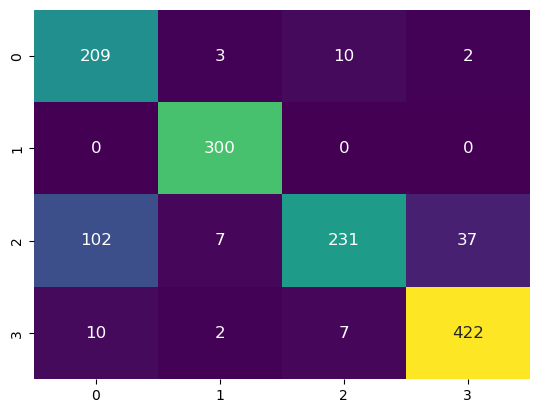

In [34]:
draw_confusion_matrix(test_images_y, test_preds_labels)

In [35]:
train_gen.class_indices

{'bad_exposition': 0,
 'bad_quality': 1,
 'good_quality_photos': 2,
 'no_person': 3}

# Пример прогноза

In [36]:
def show_image(img_path):
  im = cv2.imread(img_path)
  plt.figure(figsize = (10,10))
  plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
  plt.show()

In [37]:
mapping = dict(zip(
    train_gen.class_indices.values(), 
    train_gen.class_indices.keys()
))

In [38]:
test_df['img_path'].iloc[60]

'../dataset-001/dataset/no_person\\000000509824.jpg'

In [43]:
PATH_TO_PHOTO = '../dataset-001/dataset/no_person/000000509824.jpg'

In [44]:
image = Image.open(PATH_TO_PHOTO)
img_preprocessed = preprocess_image(image)
prediction = np.argmax(model.predict(img_preprocessed), axis=-1)[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


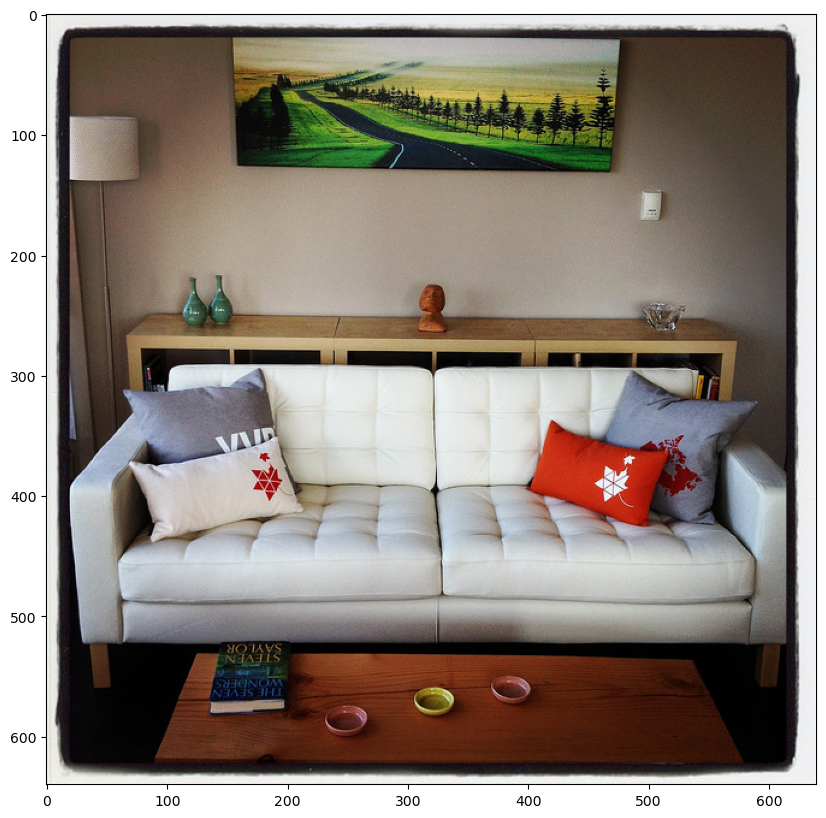

In [45]:
show_image(PATH_TO_PHOTO)

In [46]:
print(f'Model prediction: {mapping[prediction]}')

Model prediction: no_person
